# **Steup**

* Import libraries
* Load dataset


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import notebook

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [ ]:
(train_examples, train_labels), (test_examples, test_labels) = fashion_mnist.load_data()

## **Initialize Parameters**

In [ ]:
img_width = 28
img_height = 28
batch_size = 64

num_iterations_train = math.ceil(len(train_examples) / batch_size) # this is only for the progressbar
num_iterations_test = math.ceil(len(test_examples) / batch_size) # this is only for the progressbar

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
CLASS_NAMES = np.array(['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'])

# **Prepare Dataset**

In [ ]:
def mapper(image, label):
    label = tf.one_hot(label, depth=10, dtype=tf.int8) # one hot encoding
    image = tf.image.convert_image_dtype(image, tf.float32) # scaale to [0, 1] range
    return image, label

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

In [ ]:
train_ds = (train_ds.map(mapper,
                         num_parallel_calls=AUTOTUNE)
                        .shuffle(1000) 
                        .batch(batch_size)
                        .cache()
                        .repeat(1)
                        .prefetch(AUTOTUNE))

test_ds = (test_ds.map(mapper,
                         num_parallel_calls=AUTOTUNE)
                        .shuffle(1000)
                        .batch(batch_size)
                        .cache()
                        .repeat(1)
                        .prefetch(AUTOTUNE))

## **Explore Dataset**

In [ ]:
def show_batch(batch, fig_num=5):
    plt.figure(figsize = (9, 9))
    images, labels = batch[0], batch[1]
    num_of_figures = fig_num * fig_num
    for idx, img in enumerate(images):
        plt.subplot(fig_num, fig_num, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(CLASS_NAMES[labels[idx].numpy() == 1][0])
        plt.imshow(img.numpy(), cmap = plt.cm.binary)
        if idx + 1 == num_of_figures:
            break
    plt.show()

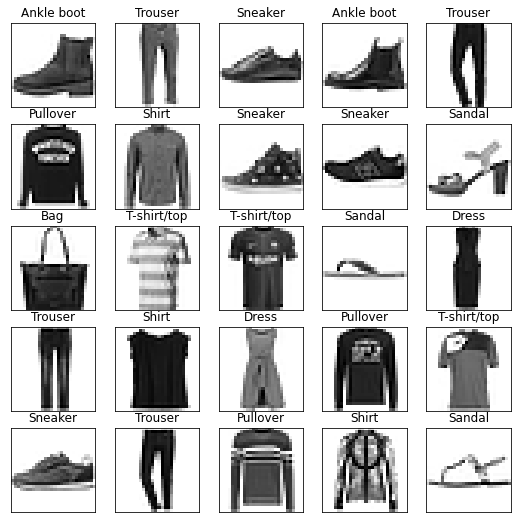

In [ ]:
show_batch(next(iter(train_ds)))

# **Model and Training**

* **Define the model**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation = tf.nn.relu, input_shape = (28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              11076608  
_________________________________________________________________
dense_7 (Dense)              (None, 10)                10250     
Total params: 11,087,498
Trainable params: 11,087,498
Non-trainable params: 0
_________________________________________________________________


* **define the loss function**


In [ ]:
def loss(y_true, y_pred):
    # you can put your custom loss here
    # Note: the custom loss should return tf.scalar
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

* **Define the optimizer**

In [ ]:
optimizer = tf.keras.optimizers.Adam()

* **Function to calculate the gradients**

In [ ]:
def grad(model,x,y):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables) # trace the model weights
        loss_val = loss(y, model(x, training=True)) # get the loss
    return loss_val, tape.gradient(loss_val, model.trainable_variables) # derive the loss function with respect to the model weights

* **Do one step training**

In [ ]:
def train_step(model, x, y):
    loss_val, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) # apply gradients on the model weights
    return loss_val

* **Class to record the losses and the accuracy during the training**

In [ ]:
class History():
    def __init__(self):
        self.loss = []
        self.accuracy = []
    
    def add_accuracy(self, accuracy):
        self.accuracy.append(accuracy)
    
    def add_loss(self, loss):
        self.loss.append(loss)    

## **Train the Model**

In [ ]:
num_epochs = 25

loss_avg = tf.keras.metrics.Mean()
accuracy_avg = tf.keras.metrics.CategoricalAccuracy()

history = History()

for epoch in range(num_epochs):
    tf.print("Epoch: {:03d}/{:03d}".format(epoch + 1, num_epochs))
    for x, y in notebook.tqdm(train_ds, total=num_iterations_train):
        loss_val = train_step(model, x, y)
        loss_avg.update_state(loss_val)
        accuracy_avg.update_state(y, model(x, training=True))
    
    history.add_accuracy(accuracy_avg.result())
    history.add_loss(loss_avg.result())
    tf.print('loss: {:.6f}, accuracy: {:.2f}'.format(loss_avg.result(),
                                                     accuracy_avg.result()))
    if accuracy_avg.result() >= .99:
        break


Epoch: 001/025



loss: 0.204676, accuracy: 0.94
Epoch: 002/025



loss: 0.180409, accuracy: 0.95
Epoch: 003/025



loss: 0.159135, accuracy: 0.95
Epoch: 004/025



loss: 0.141687, accuracy: 0.96
Epoch: 005/025



loss: 0.127412, accuracy: 0.97
Epoch: 006/025



loss: 0.115146, accuracy: 0.97
Epoch: 007/025



loss: 0.105806, accuracy: 0.97
Epoch: 008/025



loss: 0.097522, accuracy: 0.98
Epoch: 009/025



loss: 0.090006, accuracy: 0.98
Epoch: 010/025



loss: 0.083723, accuracy: 0.98
Epoch: 011/025



loss: 0.078611, accuracy: 0.98
Epoch: 012/025



loss: 0.073671, accuracy: 0.98
Epoch: 013/025



loss: 0.069498, accuracy: 0.98
Epoch: 014/025



loss: 0.065983, accuracy: 0.99
Epoch: 015/025



loss: 0.062616, accuracy: 0.99
Epoch: 016/025



loss: 0.059651, accuracy: 0.99
Epoch: 017/025



loss: 0.056963, accuracy: 0.99
Epoch: 018/025



loss: 0.054789, accuracy: 0.99
Epoch: 019/025



loss: 0.052593, accuracy: 0.99
Epoch: 020/025



loss: 0.050586, accuracy: 0.99
Epoch: 021/025



loss: 0.048800, accuracy: 0.99


# **Evaluate the Model**

* **Plot the loss**

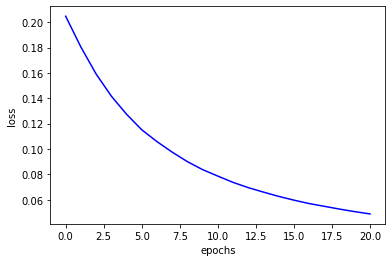

In [ ]:
plt.plot(history.loss, 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

* **Plot the accuracy**

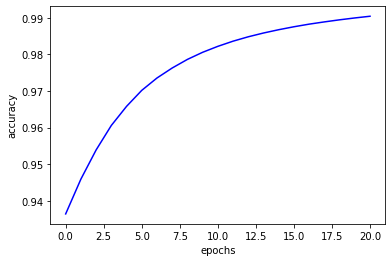

In [ ]:
plt.plot(history.accuracy,'b')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

* **Running the model on the test data**

In [ ]:
def evaluate(model, test_ds):
    acc = tf.keras.metrics.CategoricalAccuracy()
    for x, y in notebook.tqdm(test_ds, total=num_iterations_test):
        acc.update_state(y, model(x, training=True))
    print("accuracy: {:.2f}".format(acc.result()))

In [ ]:
evaluate(model, test_ds)


accuracy: 0.92
